# Experiments with MLflow (training model using Linear Regression)

Setting up experiments and recording metrics and other useful information

**Readme.md contains additional details - please take a look**

In [3]:
# install mlflow if its missing 
%pip install mlflow
%pip install missingno

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
# pandas library for i/o and dataframes 
import pandas as pd
import mlflow
import mlflow.sklearn
import missingno as msno
import matplotlib.pyplot as plt
from os.path import exists
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
# declare some constants
FIG_SIZE=(8, 6)

# test size for datasets generation
TEST_SIZE = .3

# dataset filename
DATASET_LOCAL_COPY = './static/data/CCPP_data.parquet'

### Loading data

You can use stored csv or get data from the source

In [6]:
# read data from a local folder raw_ccpp_data = pd.read_csv('MLFLow_Experiments/static/data/CCPP_data.csv')
# check if file already been downloaded 
if exists(DATASET_LOCAL_COPY) != True:
    # get data from the source 
    raw_ccpp_data = pd.read_csv('https://storage.googleapis.com/aipi_datasets/CCPP_data.csv',
                                skipinitialspace=True)

    # save data
    raw_ccpp_data.to_parquet(path=DATASET_LOCAL_COPY)
else:
    raw_ccpp_data = pd.read_parquet(DATASET_LOCAL_COPY)

In [7]:
# let us examine the resulting dataframe
raw_ccpp_data.info

<bound method DataFrame.info of          AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]>

In [8]:
# display dataframe's summary statistics
raw_ccpp_data.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


### Data cleaning step

We want to ensure that data falls with the following specifications
- Temperature (T) in the range 1.81°C to 37.11°C
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
- Net hourly electrical energy output (PE) 420.26-495.76 MW (Target we are trying to predict)

In [9]:
# query the data from raw dataframe and create new data frame
ccpp_data = raw_ccpp_data.query('(AT >= 1.81 & AT <= 37.11) &\
                                 (V >= 25.36 & V <= 81.56) &\
                                 (AP >= 992.89 & AP <= 1033.30) &\
                                 (RH >= 25.56 & RH <= 100.16)')

In [10]:
# display dataframe's summary statistics including all collumns
# we can use it to confirm the ranges as outlined above
ccpp_data.describe(include='all')

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


### Check for missing data

using this helpful utility https://github.com/ResidentMario/missingno

```...missingno provides a small toolset of flexible and easy-to-use missing data visualizations and utilities that allows you to get a quick visual summary of the completeness (or lack thereof) of your dataset. Just pip install missingno to get started.```

I am using ```msno.matrix``` as per official documentation "The msno.matrix nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion." Also take a look at the sparkline on the right as its helpful as well "The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset."


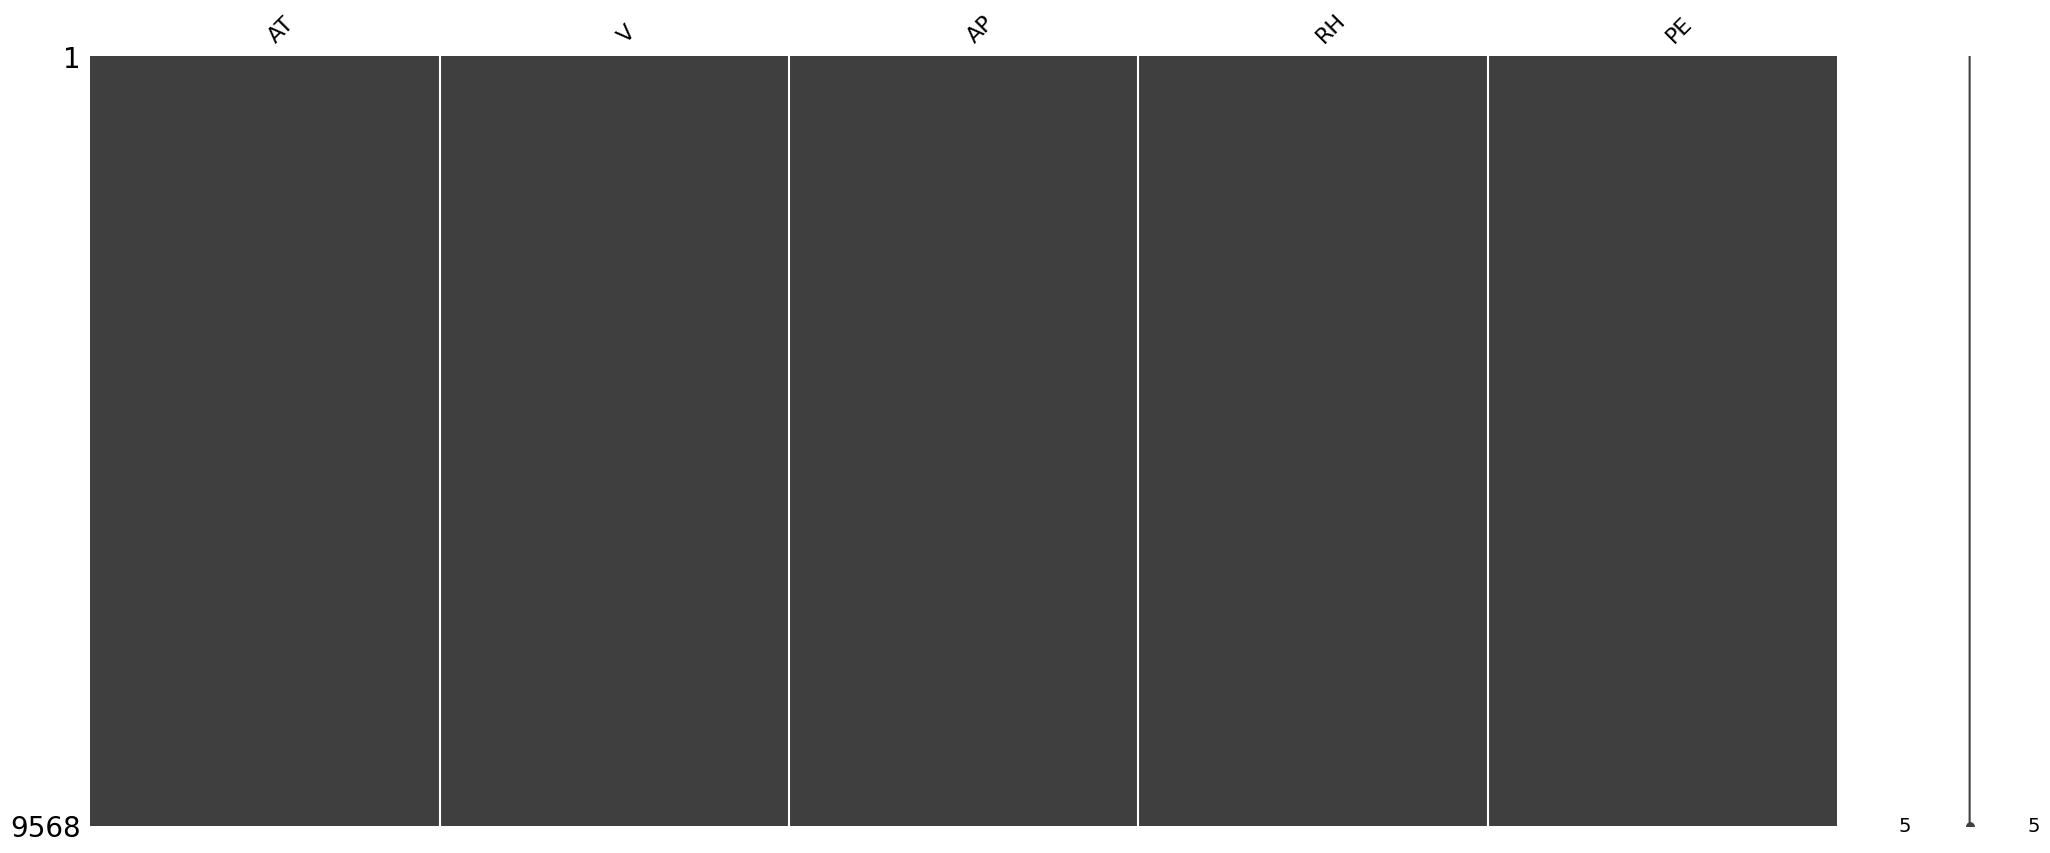

<Figure size 800x600 with 0 Axes>

In [11]:
msno.matrix(ccpp_data)
plt.figure(figsize = FIG_SIZE)
plt.show()
# absense of anything in this plot is actually a good thing - data is complete!

### Features and target selection

In [12]:
# populate data sets
def populate_dataset (columns_list):
    # we will use all 4 columns as our selected features
    X = ccpp_data.drop('PE', axis=1)
    if columns_list != None:
        X = X.drop(columns_list, axis=1)
    # Target variable - the one we want to predict
    y = ccpp_data['PE']

    return X, y

In [13]:
# populate data sets with all features 
X, y = populate_dataset(columns_list=None)

In [14]:
# rebuild train and validation datasets
# will assume 70/30 but could be changed later if needs
def rebuild_datasets (X, y):
    # 70% data for training and 30% data for test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test 

Split the data into training and testing sets

In [15]:
# 70% data for training and 30% data for test
X_train, X_test, y_train, y_test = rebuild_datasets(X, y)

Let us see what in each set

In [16]:
# training set
print("Training")
print(X_train.describe(include='all'))

Training
                AT            V           AP           RH
count  6697.000000  6697.000000  6697.000000  6697.000000
mean     19.623823    54.234805  1013.233064    73.348343
std       7.418153    12.677564     5.947802    14.644214
min       1.810000    25.360000   992.890000    26.300000
25%      13.560000    41.740000  1009.070000    63.340000
50%      20.340000    51.950000  1012.970000    75.010000
75%      25.660000    66.510000  1017.250000    84.880000
max      35.560000    81.560000  1033.300000   100.160000


In [17]:
# test set
print("Evaluation")
print(X_test.describe(include='all'))

Evaluation
                AT            V           AP           RH
count  2871.000000  2871.000000  2871.000000  2871.000000
mean     19.715165    54.471418  1013.319760    73.217154
std       7.532835    12.779040     5.918284    14.499367
min       2.340000    25.360000   993.110000    25.560000
25%      13.400000    41.720000  1009.170000    63.210000
50%      20.350000    52.840000  1012.900000    74.830000
75%      25.910000    66.560000  1017.275000    84.570000
max      37.110000    79.740000  1033.250000   100.150000


### Setup a method that we can use to validate data and calculate accuracy

In [18]:
# lets try to predict
# Input features for prediction (replace with your own feature values)
def prediction (model, drop_columns):
    new_data = pd.DataFrame({
        'AT': 14.86,
        'V': 41.66,
        'AP': 1024.06,
        'RH': 73.16,
    }, index=[0])

    if drop_columns != None:
        new_data = new_data.drop(drop_columns, axis=1)

    # PE's expected output is about
    expected_output = 463

    # Predict the electrical energy output on the new data
    predicted_energy_output = model.predict(new_data)

    return predicted_energy_output[0], expected_output

Prepare for training model and capturing experiment info with mlflow

MUST start mlflow prior to training the model. Use the following command
```mlflow ui```

to check that service is running goto
http://127.0.0.1:5000

Few important points
1. mflow is set to autolog for sklearn
2. log_models is set to True
3. log_datasets is set to True

Note: If you use set_tracking_uri(), you should set_experiment() after that.

In [19]:
experiment = None

# github generated URL - UPDATE
mlflow.set_tracking_uri('http://127.0.0.1:5000')
experiment_name = 'Training_Logistic_Regression_model_on_CCPP_data'

try:
    mlflow.set_experiment(experiment_name)
except Exception as ex:
    # api sometimes might throw an error
    print("error occured ", ex)

try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
except Exception as ex:
    # api sometimes might throw an error
    print("error occured ", ex)

print(f"Experiment {experiment}")

# enable mlflow autologging
mlflow.sklearn.autolog(disable=False,
                       log_models=True,
                       log_datasets=True,
                       registered_model_name="CCPP Logistic Regression",
                       )

Experiment <Experiment: artifact_location='mlflow-artifacts:/599470405947207898', creation_time=1694724994503, experiment_id='599470405947207898', last_update_time=1694724994503, lifecycle_stage='active', name='Training_Logistic_Regression_model_on_CCPP_data', tags={}>


Set tags that will be useful for ML runs experiments

In [20]:
# set tags - adding metadata about the model
tags = {"team": "Engineering Team Name",
        "dataset": "CCPP model",
        "release.version": "1.2.3",
        "inputs": X_train.columns,
        "target": "PE",
        "data_split":TEST_SIZE}

now = datetime.now() # current date and time
experiment_date = now.strftime("%m/%d/%Y, %H:%M:%S")

Run our experiment with linear regression model

Few points here
1. using very basic linear regression model (for simplicity)
1. setup run and use datetime stamp or some other unique identifier
1. setup multiple experiments - just removing one of the features at a time and record results 

In [21]:
# will log all the results using mlflow and then compare the results
# and select the best model
drop_columns = None
# start our experiments
for i in range (0,4):
    # when i = 0 we train model on all features
    if i == 1:
        # remove AP feature
        drop_columns = ['AP']
        X, y = populate_dataset(drop_columns)
        X_train, X_test, y_train, y_test = rebuild_datasets(X, y)
    elif i ==2:
        # remove RH and AP
        drop_columns = ['AP','RH']
        X, y = populate_dataset(drop_columns)
        X_train, X_test, y_train, y_test = rebuild_datasets(X, y)
    elif i ==3:
        # remove V and RH and AP
        drop_columns = ['AP','RH','V']
        X, y = populate_dataset(drop_columns)
        X_train, X_test, y_train, y_test = rebuild_datasets(X, y)

    # update tags to reflect
    tags.update({"inputs": X_train.columns})
    
    with mlflow.start_run(experiment_id=experiment.experiment_id,
                        run_name='linear_regression_exp__' + experiment_date):
        # save tags
        mlflow.set_tags(tags)
        # instantiate model with some hyperparameters
        model = LinearRegression(n_jobs=5)
        model.fit(X_train, y_train)

        # Predict using linear model
        y_pred = model.predict(X_test)

        # Model Evaluation
        # calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        # save metrics for future comparison in MLflow
        mlflow.log_metric('mae', mae)
        mlflow.log_metric('mse', mse)
        mlflow.log_metric('rmse', rmse)

        # let calculate prediction and some other intersting metrics
        pred, expected = prediction(model, drop_columns)
        mlflow.log_metric('prediction', pred)
        mlflow.log_metric('expected', expected)
        mlflow.log_metric('accuracy', (expected/pred)*100)

2023/09/14 13:57:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "i:\workspace\Experiments_in_DataScience\Experiments_in_DataScience\.venv\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/09/14 13:57:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "i:\workspace\Experiments_in_DataScience\Experiments_in_DataScience\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
Successfully registered model 'CCPP Logistic Regression'.
2023/09/14 13:57:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CCPP Logistic Regression, version 1
Created version '1' of model 'CCPP Logistic Regression'.
2023/09/14 13:57:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "i:\workspace\Experime

### Let us take a peak inside

We want to take a look at the coefficient and intercept 

*Intercept*: often denoted as θ₀ or beta₀, represents the value of the predicted target variable when all the input features are set to zero. In a simple linear regression model with one feature, it is equivalent to the y-intercept of the linear equation. In a multiple linear regression model with multiple features, it represents the estimated target variable value when all other input features are zero.

*Coefficients*: represent the weights assigned to each input feature in the linear equation. They indicate how much a one-unit change in a particular feature affects the predicted target variable, holding other features constant. Coefficients are often referred to as the "slopes" of the linear equation.

In summary, the intercept represents the baseline prediction when all features are zero, and the coefficients determine the magnitude and direction of the impact of each feature on the predicted target variable. In the context of linear regression modeling, these parameters are learned during the training process to best fit the observed data.

In [22]:
# The model is now trained, and you can access its parameters
# Coefficient (slope) of the linear equation (theta1)
theta1 = model.coef_

# Intercept of the linear equation (theta0)
theta0 = model.intercept_

print("Trained model parameters associated coefficients with a proper feature")
print(pd.DataFrame({"Feature":X_train.columns.tolist(),"Coefficients":theta1}))

Trained model parameters associated coefficients with a proper feature
  Feature  Coefficients
0      AT     -2.179078


Display metrics collected

1. MAE - measures the average absolute difference between the predicted values and the actual values. It gives you a sense of how far off your predictions are from the true values, without considering the direction (overestimation or underestimation).
1. MSE - calculates the average of the squared differences between predicted values and actual values. It emphasizes larger errors more than smaller ones due to the squaring.
1. RMSE - is the square root of the MSE. It provides a measure of the average magnitude of the errors in the same unit as the dependent variable, making it more interpretable.
1. R-squared - also known as the coefficient of determination, measures the proportion of the variance in the dependent variable that is predictable from the independent variables in a regression model. It ranges from 0 to 1, where 1 indicates a perfect fit and 0 indicates no linear relationship.

In summary:

- MAE focuses on the absolute magnitude of errors.
- MSE emphasizes larger errors due to squaring.
- RMSE is the square root of MSE, providing a more interpretable metric.
- R-squared measures the goodness of fit in regression models, indicating the proportion of variability explained by the model.

In [23]:
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MAE: 4.3334640468376335
MSE: 30.05836625978822
RMSE: 5.482551072246224
R-squared: 0.8974675847390025


Let us use the model we just trained and predict the output PE using sample data

In [25]:
# lets try to predict
# Input features for prediction (replace with your own feature values)
new_data = pd.DataFrame({
    'AT': 14.86,
    #'V': 41.66,
    #'AP': 1024.06,
    #'RH': 73.16,
}, index=[0])

# PE's expected output is about
expected_output = 463.26

# Predict the electrical energy output on the new data
predicted_energy_output = model.predict(new_data)

print(f"Predicted Electrical Energy Output: {predicted_energy_output[0]} and expected {expected_output}. Accuracy of {(expected_output/predicted_energy_output[0])*100}%")

2023/09/14 13:58:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "i:\workspace\Experiments_in_DataScience\Experiments_in_DataScience\.venv\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."


Predicted Electrical Energy Output: 464.78924047190367 and expected 463.26. Accuracy of 99.67098195510054%


Visualize predicted vs actual

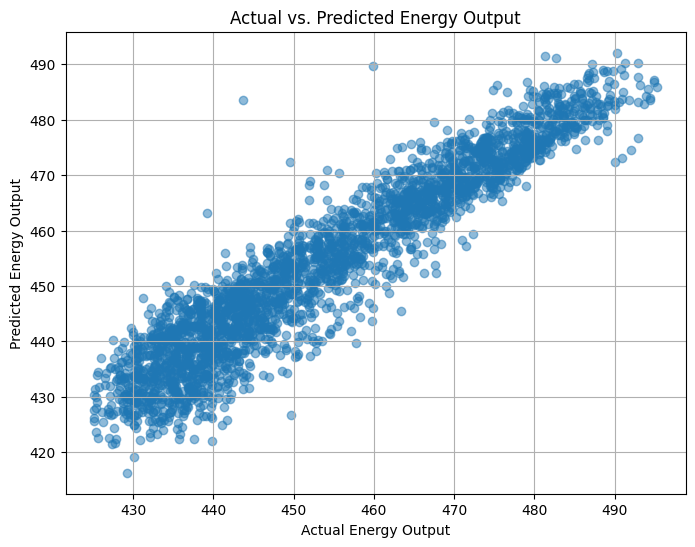

In [26]:
# scatter plot to visualize predicted va actial
# note: y_test contains the actual energy output values, and y_pred contains the predicted values

plt.figure(figsize = FIG_SIZE)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Energy Output')
plt.ylabel('Predicted Energy Output')
plt.title('Actual vs. Predicted Energy Output')
plt.grid(True)
plt.show()